In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print(f'TF version {tf.__version__}')
print(f'TFP version {tfp.__version__}')

%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')
sns.set_style('darkgrid')

TF version 2.3.0
TFP version 0.11.1


In [26]:
#@title Utility functions
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}

    return az.from_dict(trace)


def init_random(shape, n_chains=1, r=2):
    """Stanにならい、Uniform(-2, 2)で初期化する
    """
    if n_chains == 1:
        return tf.random.uniform(shape, -r, r)
    else:
        return tf.random.uniform([n_chains,] + shape, -r, r)

<AxesSubplot:>

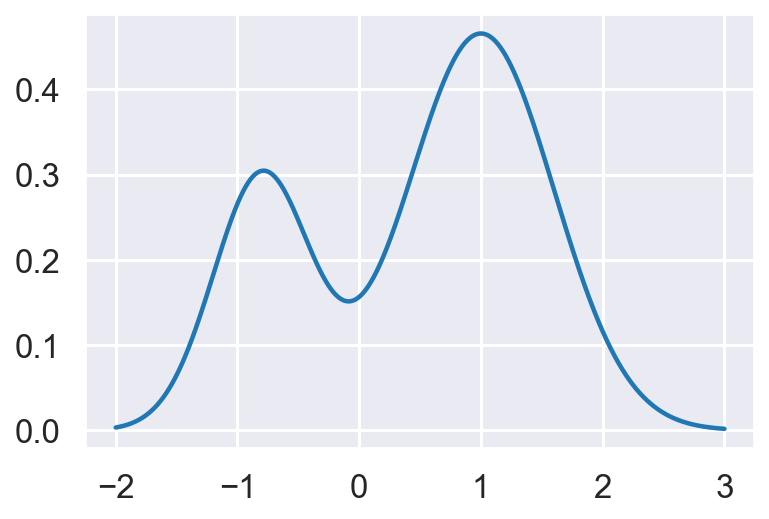

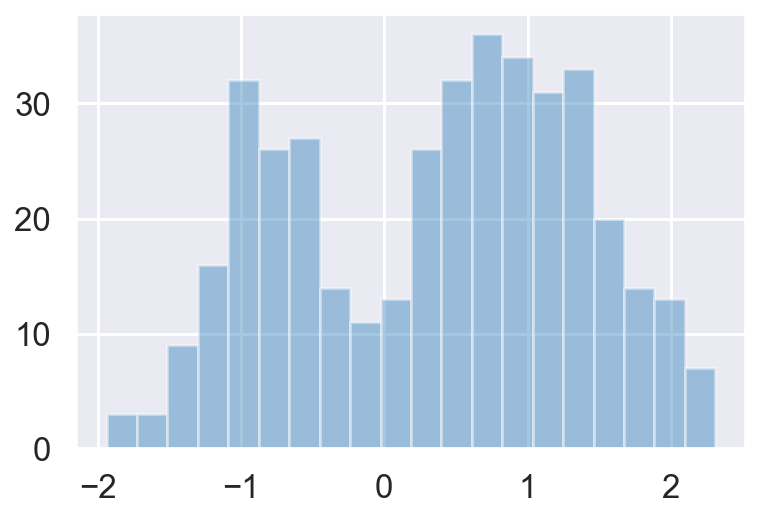

In [4]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution =tfd.Normal(
    loc=[-0.8, 1],
    scale=[0.4, 0.6]))

x = np.linspace(-2., 3., int(1e4), dtype=np.float32)
plt.plot(x, gm.prob(x))


n = 400
data = gm.sample(n, seed=0)

plt.figure()
sns.distplot(data, bins=20, kde=False)

In [10]:
n_comp = 2
Root = tfd.JointDistributionCoroutine.Root

def model():
    pi = yield Root(tfd.Dirichlet(concentration=10* tf.ones(n_comp)))
    # (E : n_comp)
    
    mu = yield Root(tfd.Independent(
    # Independent を入れて　event_shape にしておかないと複数チェーンのMCMCを実施した際にエラーになる
        tfd.Normal(loc=tf.zeros(n_comp), scale= 10 * tf.ones(n_comp)),
        reinterpreted_batch_ndims=1))
    #(E : n_comp)
    
    
    sigma = yield Root(tfd.Independent(
        tfd.HalfCauchy(loc=tf.zeros(n_comp), scale=5 * tf.ones(n_comp)),
        reinterpreted_batch_ndims=1))
    #(E : n_comp)
    
    
    y = yield tfd.Sample(
        tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=pi),
        components_distribution=tfd.Normal(loc=mu, scale=sigma)
        ),
        sample_shape=n )
    # (E : n)
    
joint = tfd.JointDistributionCoroutine(model)
    
    
def target_log_prob(pi, mu, sigma):
    return tf.reduce_sum(joint.log_prob(pi, mu, sigma,data))

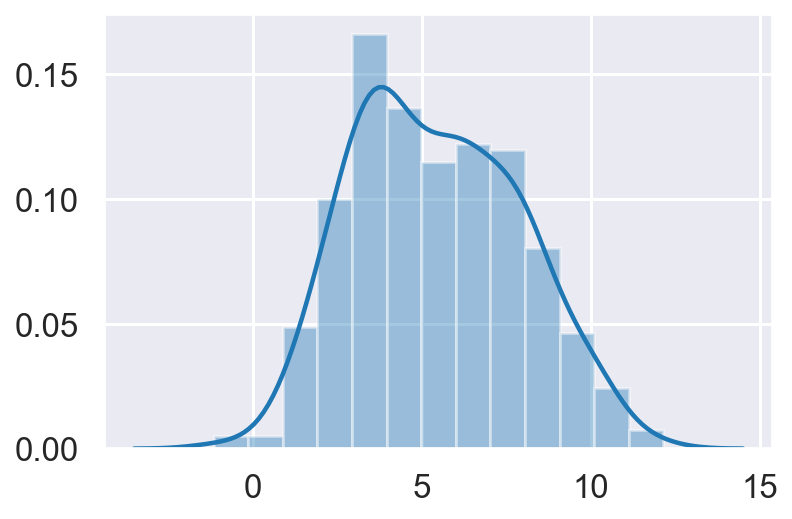

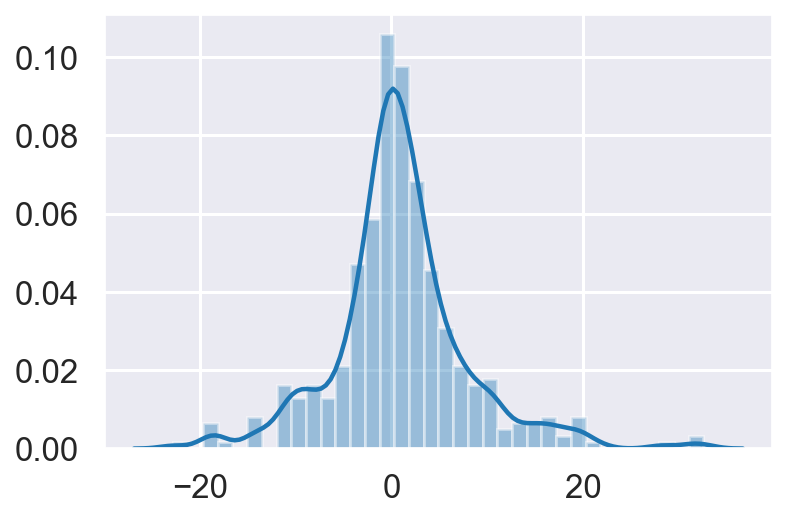

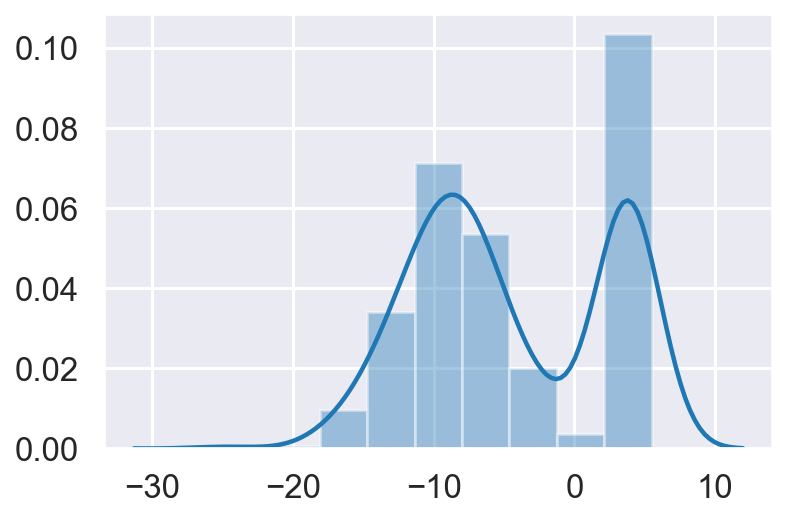

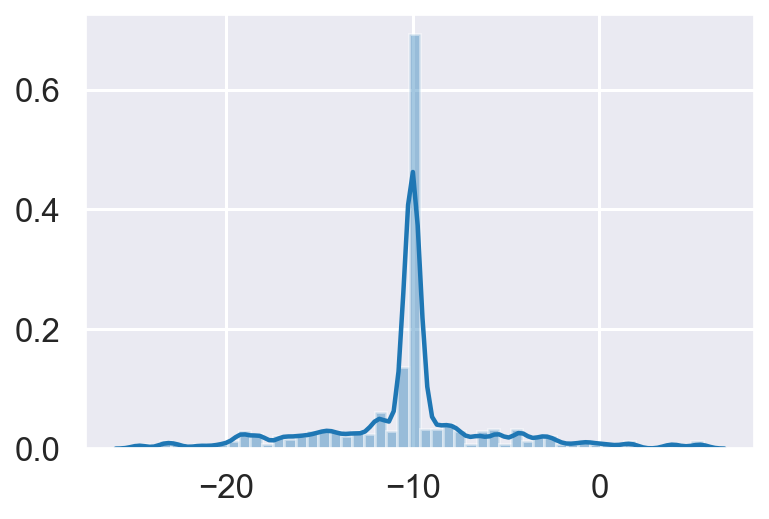

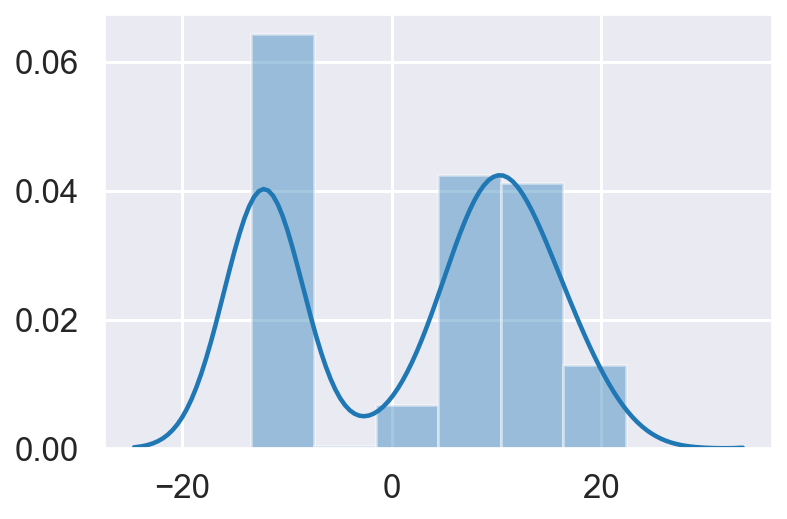

In [11]:
# 事前分布を用いたシミュレーション

y_sample = joint.sample(5)[-1]


for y_s in y_sample:
    plt.figure()
    sns.distplot(y_s)

In [15]:
dtypes = np.float32
n_chains = 3

initial_state = [
    tf.random.uniform((n_chains, n_comp), 0, 1, name="init_pi"),
    tf.random.uniform((n_chains, n_comp), -2, 2, name="init_mu"),
    tf.random.uniform((n_chains, n_comp), 0, 2, name="init_sigma")
]

unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Softplus()
]

In [18]:
%%time

def sample():
    return tfp.mcmc.sample_chain(
    num_results = 4000,
    num_burnin_steps=1000,
    current_state=initial_state,
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
        step_size=0.01,
        num_leapfrog_steps=5),
    bijector = unconstraining_bijectors),
    num_adaptation_steps=400),
    trace_fn = lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

states, is_accepted = sample()

CPU times: user 8min 3s, sys: 520 ms, total: 8min 4s
Wall time: 8min 4s


In [19]:
print('acceptance rate: {:.1%}'.format(is_accepted.numpy().mean()))

acceptance rate: 66.3%


array([[<AxesSubplot:title={'center':'mix_prob\n0'}>,
        <AxesSubplot:title={'center':'mix_prob\n0'}>],
       [<AxesSubplot:title={'center':'mix_prob\n1'}>,
        <AxesSubplot:title={'center':'mix_prob\n1'}>],
       [<AxesSubplot:title={'center':'loc\n0'}>,
        <AxesSubplot:title={'center':'loc\n0'}>],
       [<AxesSubplot:title={'center':'loc\n1'}>,
        <AxesSubplot:title={'center':'loc\n1'}>],
       [<AxesSubplot:title={'center':'scale\n0'}>,
        <AxesSubplot:title={'center':'scale\n0'}>],
       [<AxesSubplot:title={'center':'scale\n1'}>,
        <AxesSubplot:title={'center':'scale\n1'}>]], dtype=object)

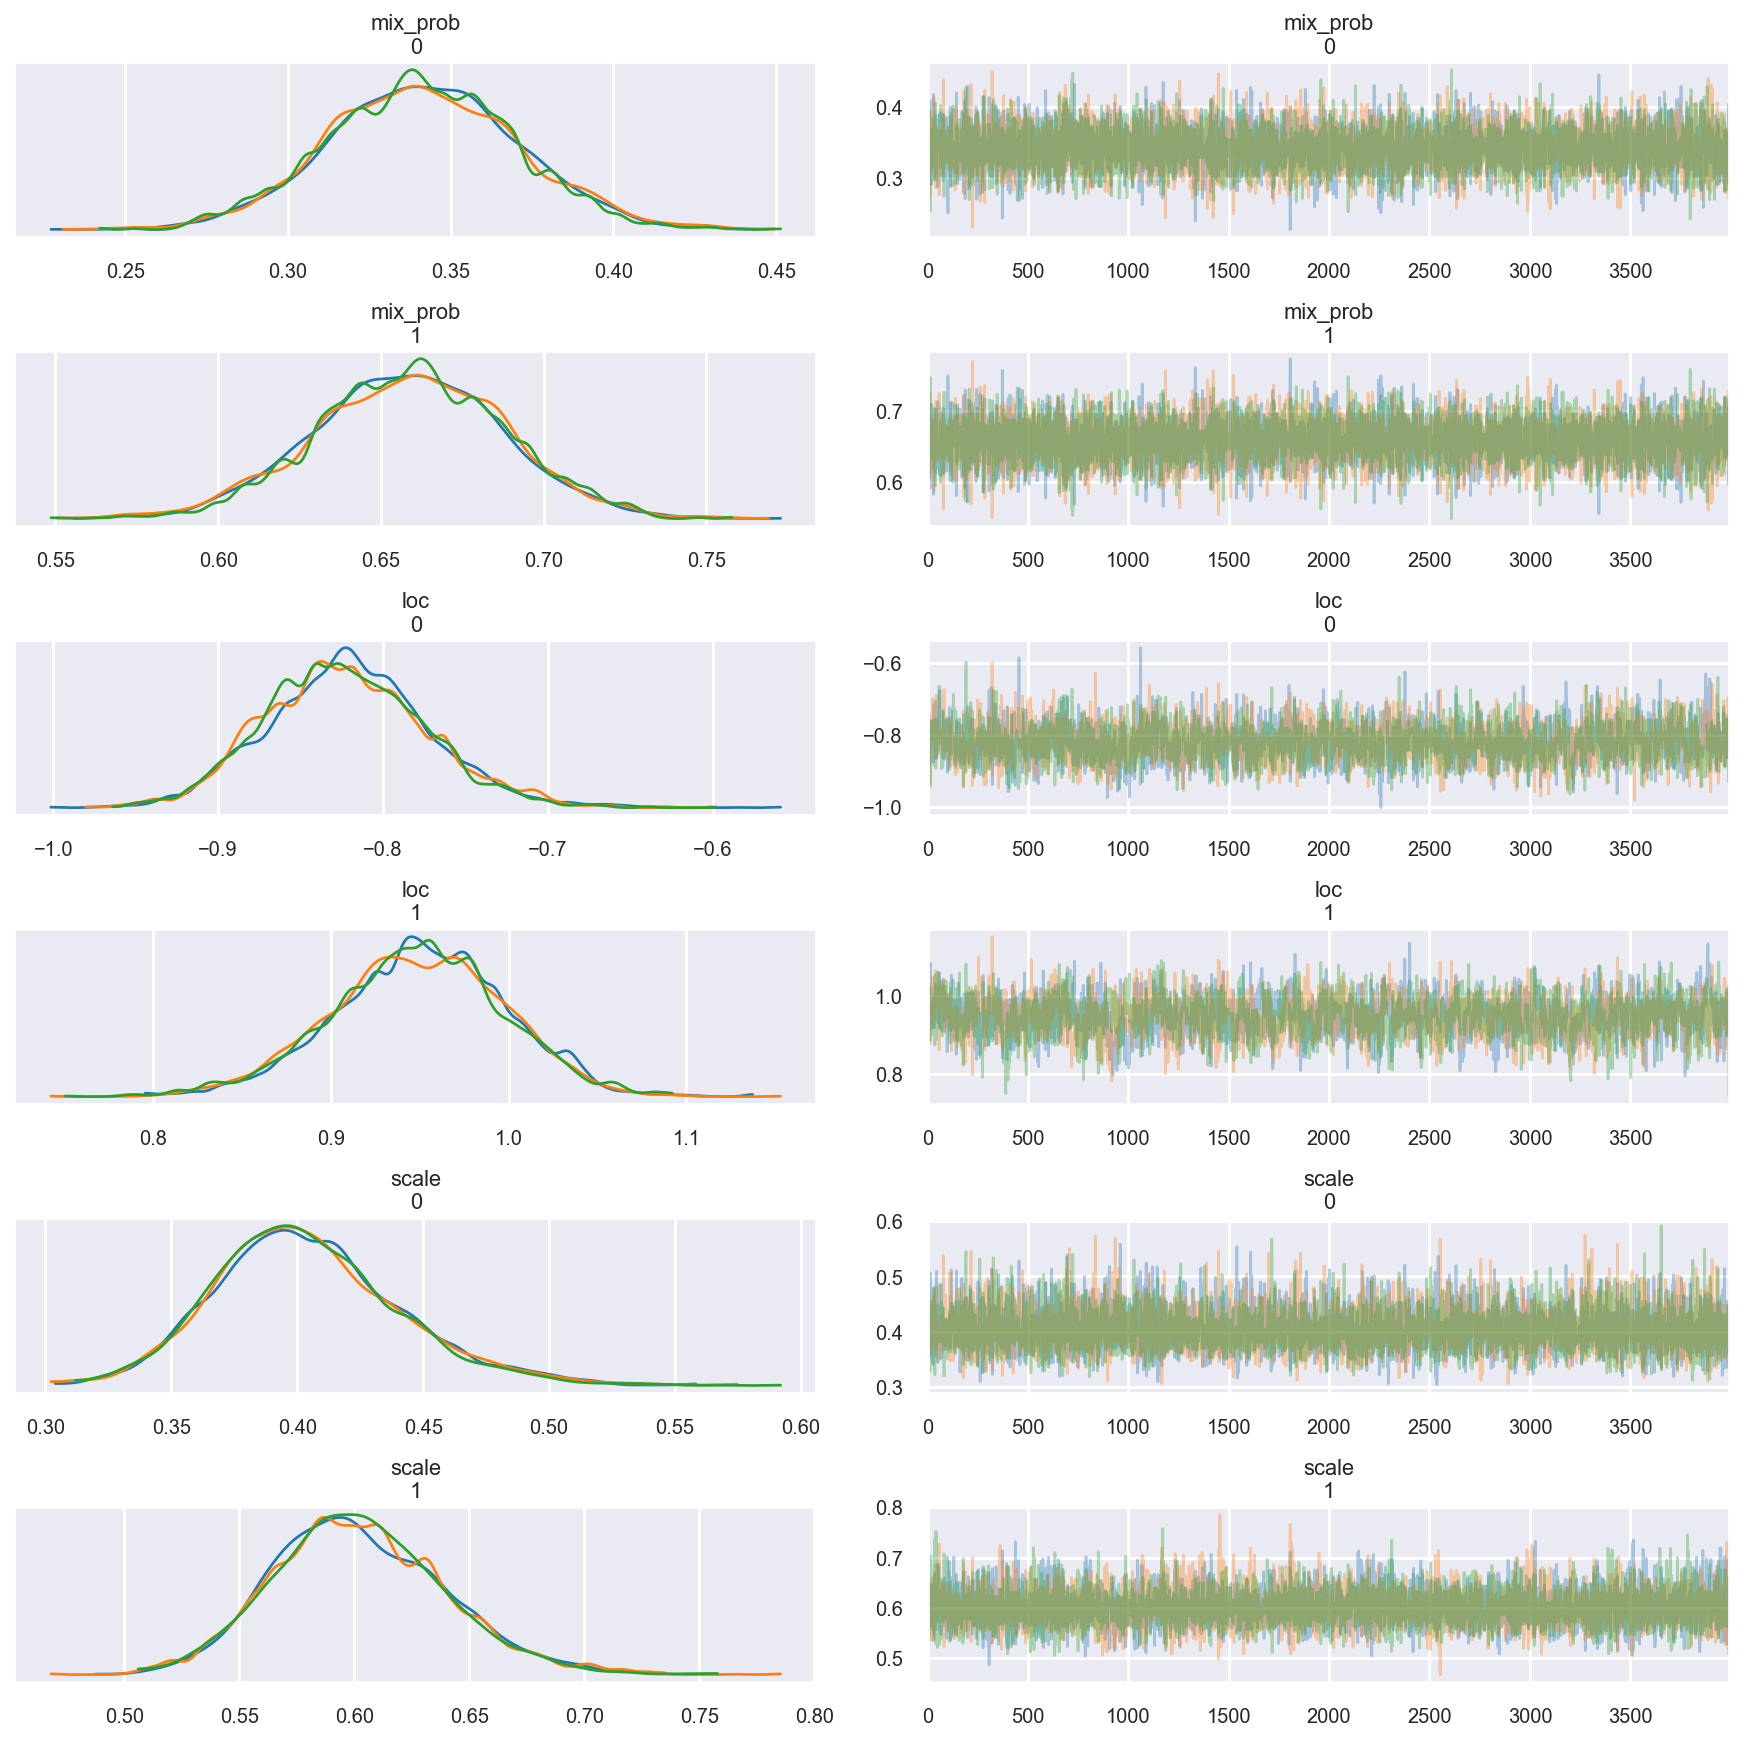

In [27]:
var_name = ["mix_prob", "loc", "scale"]
trace = format_trace(states, var_name, chain_dim=1)
az.plot_trace(trace)

In [28]:
# 1つ目のchainだけ取り出す
trace = format_trace([s[:, 0, :] for s in states], var_name)
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mix_prob[0],0.342,0.029,0.289,0.398,0.001,0.000,2405.0,2405.0,2400.0,1868.0,NaN
mix_prob[1],0.658,0.029,0.602,0.711,0.001,0.000,2405.0,2393.0,2400.0,1868.0,NaN
loc[0],-0.820,0.049,-0.913,-0.732,0.002,0.002,432.0,429.0,433.0,747.0,NaN
loc[1],0.952,0.048,0.868,1.044,0.003,0.002,310.0,310.0,316.0,625.0,NaN
scale[0],0.405,0.037,0.338,0.478,0.001,0.000,2939.0,2881.0,2992.0,1326.0,NaN
scale[1],0.602,0.037,0.533,0.671,0.001,0.000,3131.0,3021.0,3313.0,1089.0,NaN
